## Toolbox

In [27]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
# from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\ProgramData\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


### Cheatsheets

[Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#links)

[DataColor](https://learnui.design/tools/data-color-picker.html)

[LaTeX math](https://kapeli.com/cheat_sheets/LaTeX_Math_Symbols.docset/Contents/Resources/Documents/index)

[Python Beginner](file:///C:/Users/racco/Downloads/papers/beginners_python_cheat_sheet_pcc_all.pdf)

[Python Matplotlib](file:///C:/Users/racco/Downloads/papers/Python_Matplotlib_Cheat_Sheet.pdf)

[Python Numpy](file:///C:/Users/racco/Downloads/papers/Numpy_Python_Cheat_Sheet.pdf)

[Python Pandas](file:///C:/Users/racco/Downloads/papers/Python_Pandas_Cheat_Sheet_2.pdf)

[Python Scipy](file:///C:/Users/racco/Downloads/papers/Python_SciPy_Cheat_Sheet_Linear_Algebra.pdf)


### Data processing scripts

In [3]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [4]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], 
                                                     index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], 
                                                     index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

### Plotting

#### Update and flush inline outputs

In [5]:
import sys, time

N = 100
for j in range(int(N/30)):
    for i in range(N):
       time.sleep(0.05)
       sys.stdout.flush()
#        sys.stdout.write("\r{:.1f} %".format(i/N*100))
       print("{:.1f} %".format(i/N*100), end="\r")

#### Quick viewing DC results

<IPython.core.display.Javascript object>


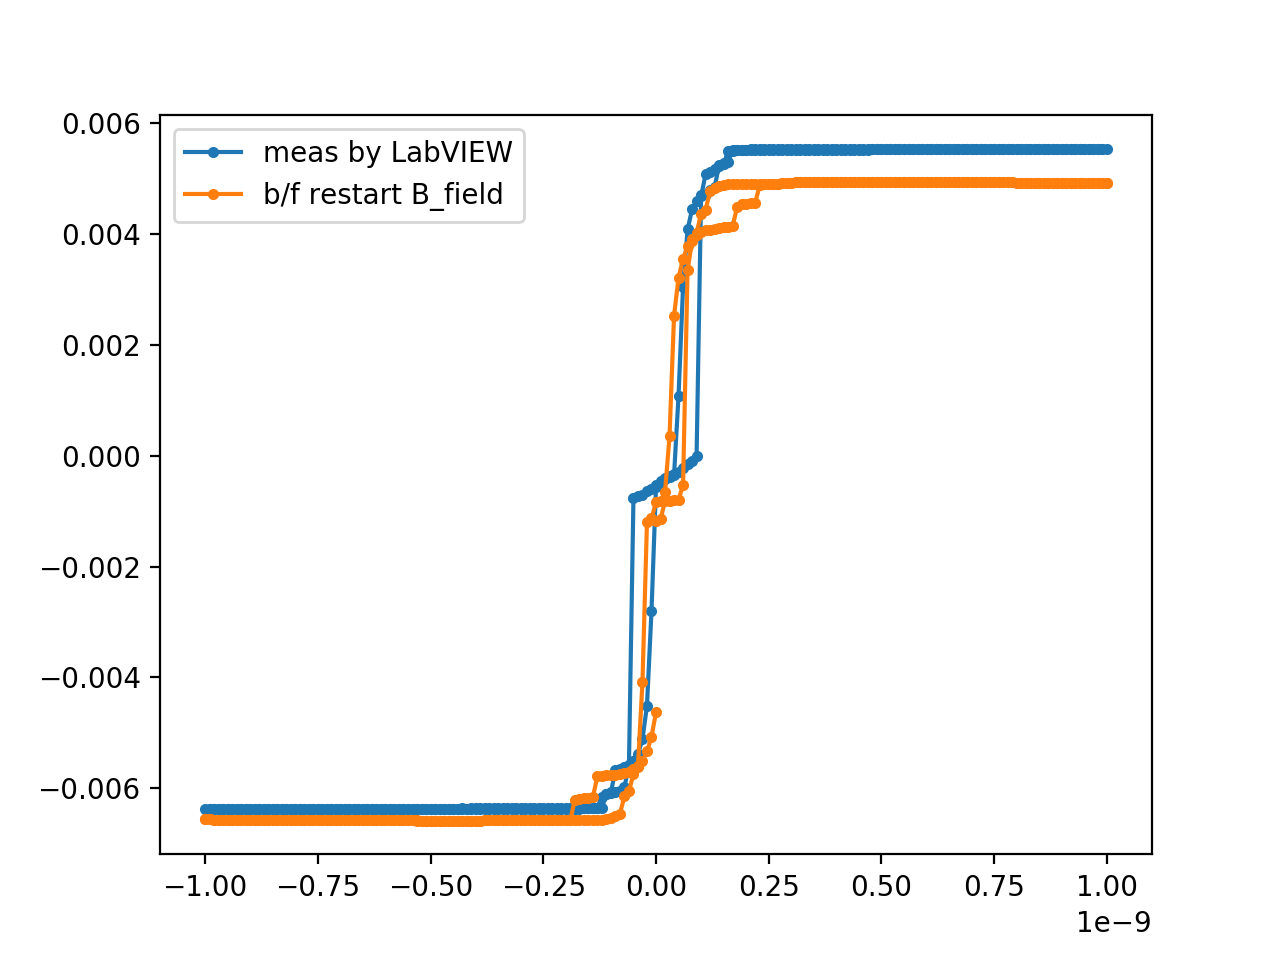

In [6]:
filepath = r'C:\Users\racco\Documents\2experimental log toolbox'

f,ax=plt.subplots()
dataLV = filetoDFM(filepath + r'\191104-70N3_IVc-115218.txt')
ax.plot(dataLV[0]['IS'],dataLV[0]['V1'], '.', ls='-',label = 'meas by LabVIEW')

qc.config["core"]["db_location"] = filepath + r'\Experiments_{}.db'.format('70B1N5')   
initialise_database()

label = ['b/f restart B_field']
for i,v in enumerate([1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    ax.plot(Is, Vs, '.', ls='-', label = '{}'.format(label[i]))

ax.legend()

#### Bar plots

<IPython.core.display.Javascript object>


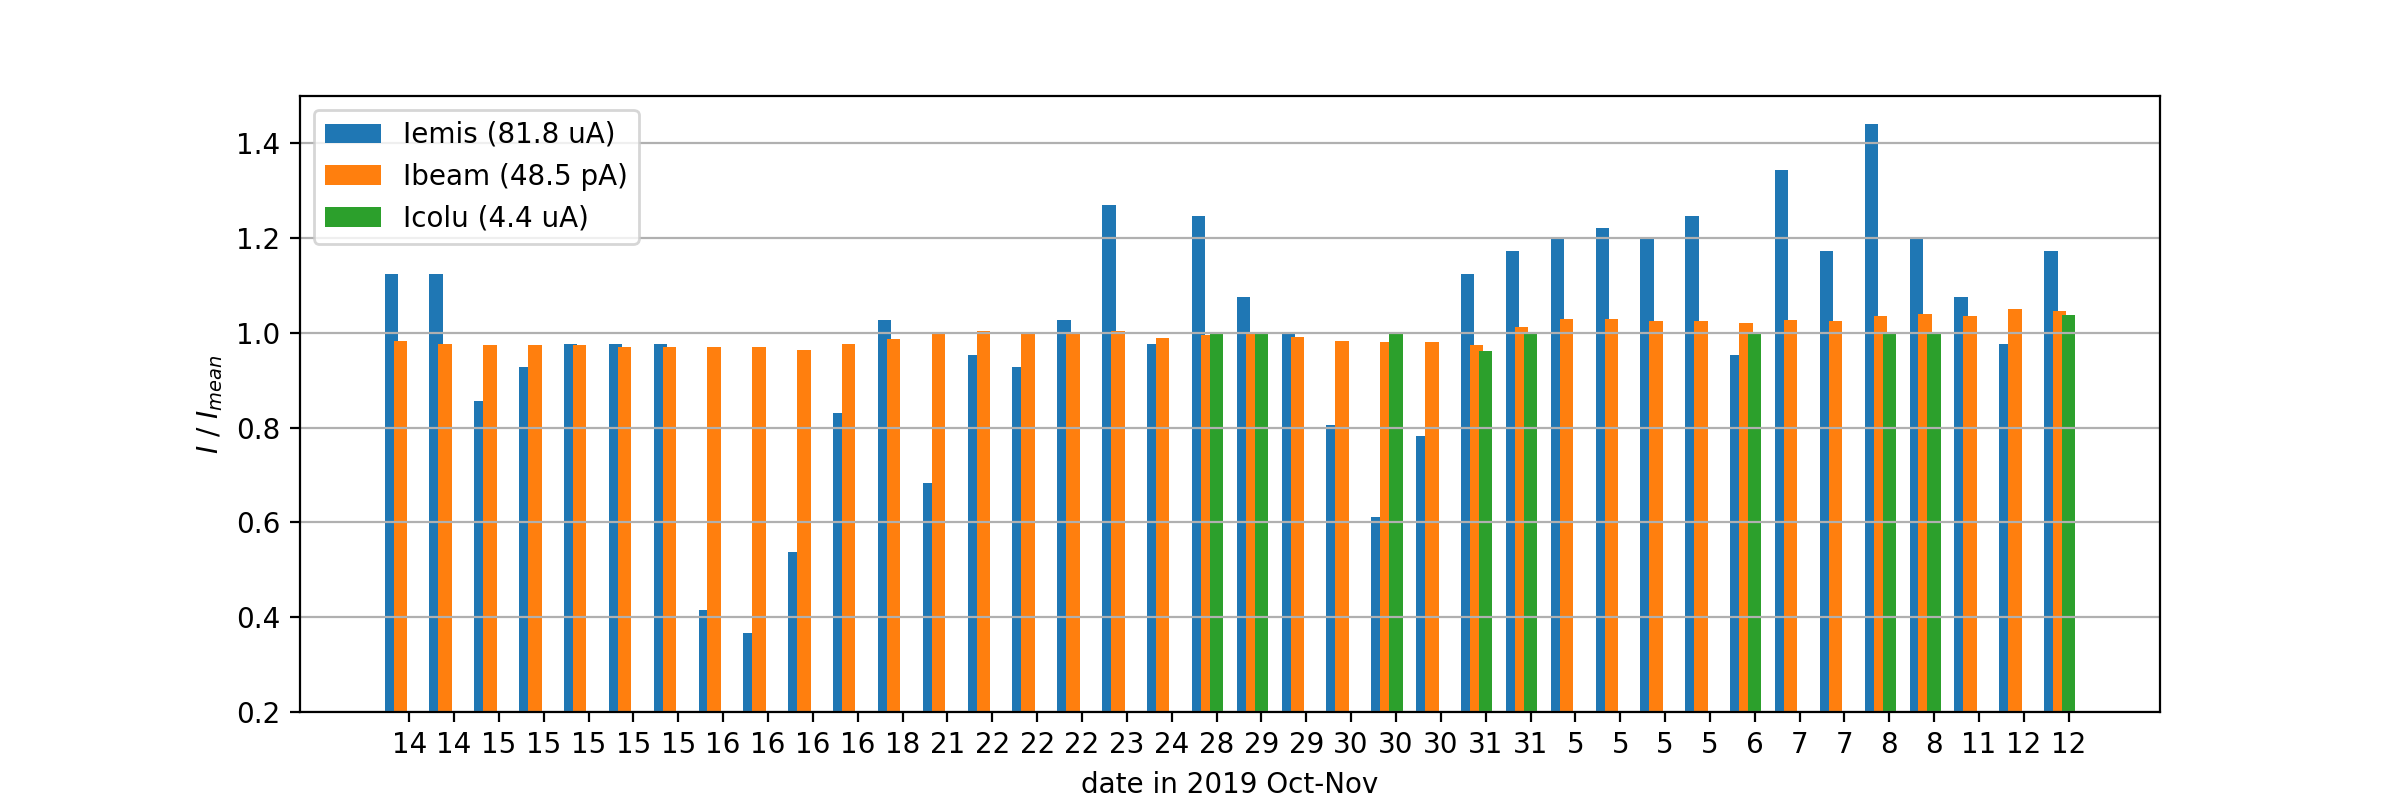

In [25]:
def lstmean (lst):
    for i,v in enumerate (lst):
        if v == 0:
            lst[i] = np.nan
    return np.nanmean(lst)

date = [ 14   , 14   , 15   , 15   , 15   , 15   , 15   , 16   , 16   , 16   , 16   , 18   , 21   , 22   , 22   , 22   , 23   , 24   , 28   , 29   , 29   , 30   , 30   , 30   , 31   , 31   , 5    , 5    , 5    , 5    , 6    , 7    , 7    , 8    , 8    , 11   , 12   , 12    ]
Iemi = [ 92   , 92   , 70   , 76   , 80   , 80   , 80   , 34   , 30   , 44   , 68   , 84   , 56   , 78   , 76   , 84   , 104  , 80   , 102  , 88   , 82   , 66   , 50   , 64   , 92   , 96   , 98   , 100  , 98   , 102  , 78   , 110  , 96   , 118  , 98   , 88   , 80   , 96    ]
Ibe1 = [ 47.6 , 47.3 , 47.2 , 47.2 , 47.2 , 47.0 , 47.0 , 47.0 , 47.0 , 46.7 , 47.3 , 47.8 , 48.4 , 48.7 , 48.5 , 48.5 , 48.7 , 47.9 , 48.2 , 48.5 , 48   , 47.6 , 47.5 , 47.5 , 47.2 , 49.1 , 49.9 , 49.9 , 49.7 , 49.7 , 49.5 , 49.8 , 49.7 , 50.2 , 50.4 , 50.2 , 50.9 , 50.7  ]
Icol = [ 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    ,  0   , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 4.354, 4.354, 0    , 0    , 4.354, 0    , 4.187, 4.354, 0    , 0    , 0    , 0    , 4.354, 0    , 0    , 4.354, 4.354, 0    , 0    , 4.522 ]
x = np.linspace(1,len(date),len(date))

Iemimean = lstmean(Iemi)
Ibe1mean = lstmean(Ibe1)
Icolmean = lstmean(Icol)

f,ax = plt.subplots (1,1,figsize=(12,4))
ax.bar(x    , Iemi/Iemimean, width=0.3, tick_label = date, 
       label = 'Iemis ({}uA)'.format(si_format(Iemimean)))
ax.bar(x+0.2, Ibe1/Ibe1mean, width=0.3, tick_label = date, 
       label = 'Ibeam ({}pA)'.format(si_format(Ibe1mean)))
ax.bar(x+0.4, Icol/Icolmean, width=0.3, tick_label = date, 
       label = 'Icolu ({}uA)'.format(si_format(Icolmean)))
# plt.xlim(0,20)
ax.set_ylim(0.2,1.5)
ax.set_xlabel("date in 2019 Oct-Nov")
ax.set_ylabel("$I$ / $I_{mean}$")
ax.legend(loc=2)
ax.grid(True, 'both', axis = 'y')

#### Pie chart

<IPython.core.display.Javascript object>


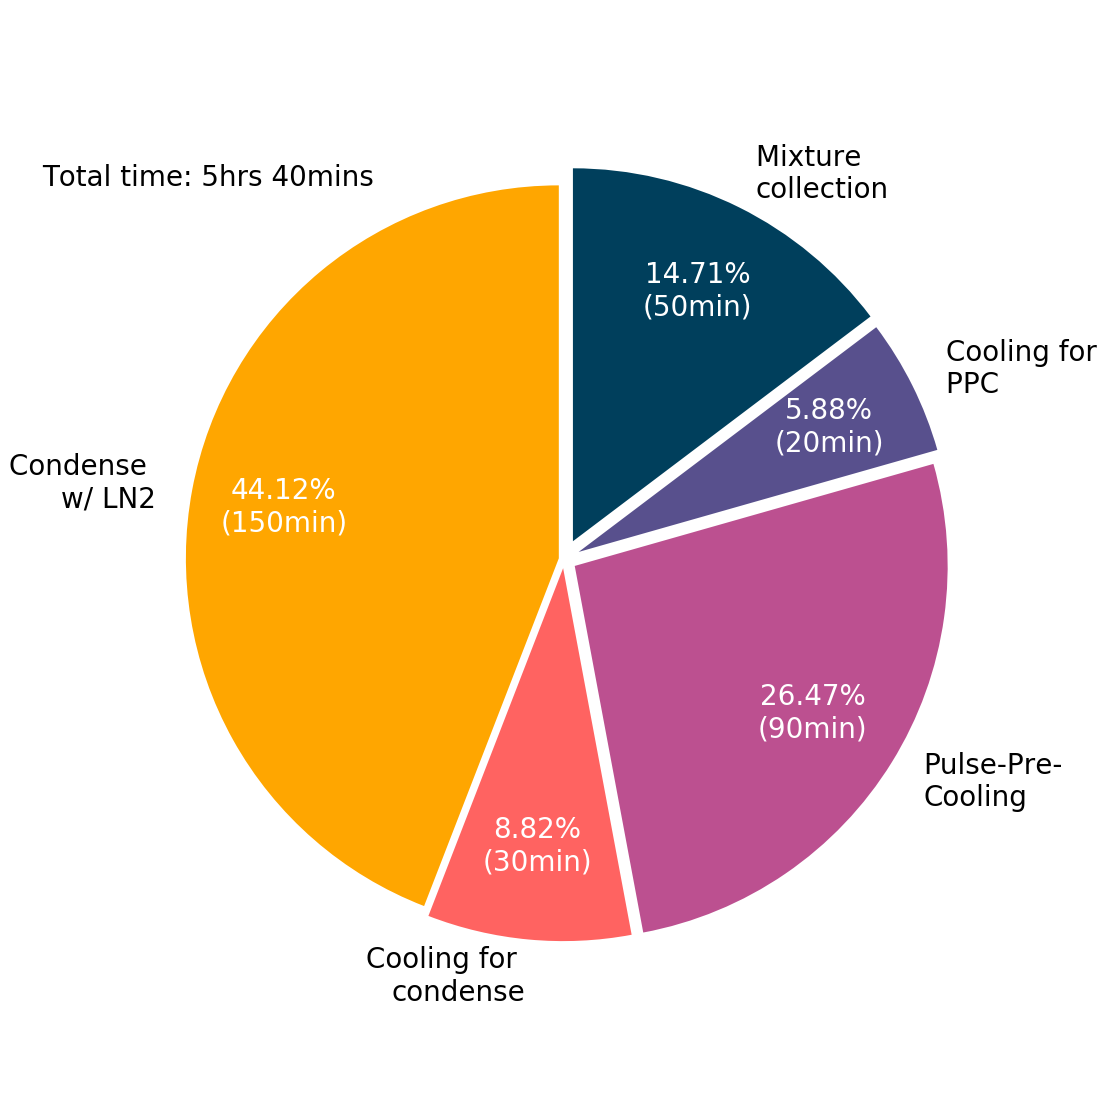

In [26]:
def min2hr(time='1hr20min'):
    hr, minu = time.split('hr')[0], time.split('hr')[1][:-3]
    return int(hr)*60+int(minu)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d}min)'.format(p=pct,v=val)
    return my_autopct


labels = ['Mixture \ncollection', 
          'Cooling for \nPPC ', 
          'Pulse-Pre-\nCooling',
          'Cooling for \ncondense',
          'Condense \nw/ LN2']

sizes =  [min2hr('0hr50min'), 
          min2hr('0hr20min'), 
          min2hr('1hr30min'), 
          min2hr('0hr30min'), 
          min2hr('2hr30min')]

colors = [[0    , 0.247, 0.361], 
          [0.345, 0.314, 0.553], 
          [0.737, 0.314, 0.565], 
          [1    , 0.388, 0.38 ],
          [1    , 0.651, 0    ],]

expldlst = np.array([])
for i in range(5):
    expldlst = np.append(expldlst, (1.35-i*0.25)/25)
explode = expldlst

_, _, autotexts = plt.pie(sizes, explode = explode, labels = labels, colors = colors, shadow = False,
                          autopct = make_autopct(sizes), startangle = 90, counterclock = False,
                          pctdistance=0.75, labeldistance=1.1)
for autotext in autotexts:
    autotext.set_color('white')

# '%1.1f%%'
plt.axis('equal')
plt.text(-1.4,1,'Total time: {}hrs {}mins'.format(int(np.floor(sum(sizes)/60)), 
                                                  np.remainder(sum(sizes),60)))
fig = plt.gcf()
fig.set_size_inches(5.5,5.5)
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)
plt.show()

### Pandas list and dictionary

#### Log ids 

In [167]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[              [8,9,10],  43e-3, np.array([ZF,midF,FF])              ,   4e-3, 'quick IVc meas'  ],  
       [                  [13],  43e-3, 　 4e-3, ''                ],  
       [range(  22,   42+1)[:],  50e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  43,   63+1)[:], 100e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  64,   84+1)[:], 150e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  85,  105+1)[:], 200e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 106,  126+1)[:], 250e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 127,  147+1)[:], 300e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 148,  168+1)[:], 350e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 169,  189+1)[:], 400e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 190,  210+1)[:], 450e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 211,  231+1)[:], 500e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 232,  252+1)[:], 550e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 253,  262+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc_ada'],  
#        [range( 263,  272+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],  
       [range( 273,  282+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],    
       [range( 286,  336+1)[:],  43e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at Tbase'   ],    
       [range( 337,  387+1)[:],  75e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at  75mK'   ],    
       [range( 388,  438+1)[:], 125e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 125mK'   ],    
       [range( 439,  489+1)[:], 175e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 175mK'   ],    
       [range( 490,  540+1)[:], 225e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 225mK'   ],    
       [         [541,542,543],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB,  no attn'  ],    
       [         [544,545,546],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB, 10x attn'  ]]

ex74N4 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

NameError: name 'udu_list' is not defined

In [ ]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()

T = 43e-3
idlst = ex74N4[ex74N4['T'] == T]['ids'].tolist()[-2:]
for j,idl in enumerate(idlst):
    for i,v in enumerate(idl):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.',ls='-',label = '$T={}K$'.format(si_format(T)))#alpha=1-0.99*i ,  
        ax[j].set_xlabel('$I(A)$')
        ax[j].set_ylabel('$V(V)$')
        ax[j].set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
        ax[j].grid('both')
        ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### Q1D list

In [2]:
Q1Dlst

NameError: name 'Q1Dlst' is not defined

In [ ]:
Q1Dlst['EJ/JJ']['63BAN6']

In [ ]:
D55BCN7  = [(0.030,   0.465, 0.214,     0      ,      0     ,     0     ,     20,      2),
            (0.300,   0.465, 0.214,     0      ,      0     ,     0     ,     16,      2)]

In [ ]:
D53N2    = [(0.030,   0.465, 8.131,     0      ,      0     ,     0     ,     20,      2)

In [ ]:
D55B1N9  = [(0.030,   0.465, 0.660,     0      ,      0     ,     0     ,     20,      2)

In [ ]:
D59B6N3  = [(0.030,   0.465, 0.905,     0      ,      0     ,     0     ,     20,      2)

In [ ]:
D59B0N1  = [(0.030,   0.465, 0.857,     0      ,      0     ,     0     ,      2,      2)

In [ ]:
D59BBN2  = [(0.030,   0.465, 0.044,     0      ,      0     ,     0     ,     20,      2)

In [ ]:
D62B3N2  = [(0.030,   0.465, 0.358,     0      ,      0     ,     0     ,     20,      2)

In [ ]:
D60B2N6  = [(0.030,   0.465, 0.408,     0      ,      0     ,     0     ,     20,      2)

In [ ]:
D60B2N2  = [(0.030,   0.465, 0.128,     0      ,      0     ,     0     ,      4,      2)

In [ ]:
D63BAN6  = [(0.030,   0.465, 0.238,     0      ,      0     ,     0     ,     30,      2),
            (     ,   0.465, 0.238,     0      ,      0     ,     0     ,     30,      2)]

In [ ]:
D070     = [(0.030,   0.038, 0.763,     0      ,      0     ,     0     ,     16,      2)]

In [ ]:
samples  = [(0.030,   0.465, 0.214,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 8.131,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 0.660,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 0.905,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 0.857,     0      ,      0     ,     0     ,      2,      2),
            (0.030,   0.465, 0.044,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 0.358,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 0.408,     0      ,      0     ,     0     ,     20,      2),
            (0.030,   0.465, 0.128,     0      ,      0     ,     0     ,      4,      2),
            (0.030,   0.465, 0.238,     0      ,      0     ,     0     ,     30,      2),
            (0.030,   0.038, 0.763,     0      ,      0     ,     0     ,     16,      2)]


In [ ]:
# samples = np.array([])

# Ddevlst =  [D55BCN7, D53N2, D55B1N9, D59B6N3, D59B0N1, D59BBN2, D62B3N2, D60B2N6 , D60B2N2 , D63BAN6 , D070]
# for devid in Ddevlst:
#     samples = np.append(samples, devid)

Q1Dlst = pd.DataFrame(samples, 
 columns = [  'T8', 'EJ/JJ', 'ECJ', 'ISW'      , 'R0ZF'     , 'R0FF'     , '#ser', '#par'],
# units  = [    'K',    'K',   'K',   'A, tot' , 'ohm, tot' , 'ohm, tot' ,   'ea',   'ea'],
 index = ['55BCN7', '53N2', '55B1N9', '59B6N3', '59B0N1', '59BBN2', '62B3N2', '60B2N6' , '60B2N2' , '63BAN6' , '070'])

Q1Dlst

In [ ]:
devlst =  ['55BCN7', '53N2', '55B1N9', '59B6N3', '59B0N1', '59BBN2', '62B3N2', '60B2N6' , '60B2N2' , '63BAN6' , '070']

ToEJlst  = np.array([])
EJoEClst = np.array([])

for devid in devlst:
    ToEJ  = Q1Dlst[   'T8'][devid]/Q1Dlst['EJ/JJ'][devid]
    ToEJlst = np.append(ToEJlst, ToEJ)
    EJoEC = Q1Dlst['EJ/JJ'][devid]/Q1Dlst['ECJ'  ][devid]
    EJoEClst= np.append(EJoEClst, EJoEC)

f,ax=plt.subplots()
ax.scatter(EJoEClst, ToEJlst)
ax.set_ylabel('T/EJ')
ax.set_xlabel('EJ/EC')

# for i, v in enumerate(devlst):
#     ax.annotate(v, (EJoEClst[i], ToEJlst[i]))

#### Dome

In [ ]:
pd.set_option("display.precision", 3)

In [164]:
# Dome from literature
key =  [ '$T_C$', '$\\rho$']
lst = [[ 2.4  ,  100e-8 ],
       [ 3.0  ,  500e-8 ],
       [ 2.5  , 2000e-8 ],
       [ 2.7  ,  180e-8 ],
       [ 2.8  ,  350e-8 ],
       [ 3.1  ,  500e-8 ],
       [ 2.2  , 3200e-8 ]]

domeLitDF =   pd.DataFrame(  data  = list(zip(*lst)), 
                           columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                             index = key ).transpose()

In [152]:
# Dome for wet-grAl
key =  [ 'Device'        ,    'THK', '$T_C$',  '$I_C$', '$R_s$', '$\\rho$', '$T0_C$', '$T1_C$', ]
lst = [[ 'ALOX06'        , 52.7e-6 ,   1.39 , 5.65e-6 ,    844 ,  19.2e-5 ,   1.39 ,   1.39 , ],
       [ 'ALOX05B_10um'  ,   35e-9 ,    1.7 , 0.41e-6 ,   1662 ,   4.2e-5 ,    1.7 ,    1.7 , ],
       [ 'ALOX05B_2um'   ,   28e-9 ,    1.7 ,  3.3e-6 ,   1315 ,   4.2e-5 ,    1.7 ,    1.7 , ],
       [ 'ALOX05B_.5um'  ,   20e-9 ,   1.75 , 12.5e-6 ,   2095 ,   9.9e-5 ,   1.75 ,   1.75 , ],
       [ 'ALOX03'        ,  140e-9 ,    1.2 ,  4.6e-6 ,   1317 , 12.15e-5 ,   1.75 ,   1.75 , ],
       [ 'ALOX07_10um'   ,   40e-9 ,   1.73 , 14.5e-6 ,    706 ,  3.09e-5 ,   1.75 ,   1.75 , ],
       [ 'Q1D066B8'      ,   40e-9 ,   1.80 , 12.5e-6 ,   1048 ,  4.55e-5 ,   1.75 ,   1.75 , ],
       [ 'Q1D067B8'      ,   40e-9 ,   2.00 , 12.5e-6 ,    988 ,  3.82e-5 ,   1.75 ,   1.75 , ]]

domeWetDF =   pd.DataFrame(  data  = list(zip(*lst)), 
                             columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                               index = key ).transpose()

In [151]:
# Dome for dry-grAl
key =  [ 'Device'        ,  '$\\rho$',  '$T_C$',]
lst = [[ 'aka5bN8_Up'    ,  9.425e-6 ,    2.03 ,],
       [ 'aka5bN8_Mid'   ,  9.425e-6 ,    1.95 ,],
       [ 'aka5bN8_Dow'   ,  9.425e-6 ,    1.85 ,],
       [ 'aka6bN8_Up'    ,  5.200e-6 ,  np.nan ,],
       [ 'aka6bN8_Mid'   ,  5.200e-6 ,    2.02 ,],
       [ 'aka6bN8_Dow'   ,  5.525e-6 ,    1.95 ,],
       [ 'SiOx002N8_Mid' ,  2.200e-7 ,  np.nan ,],
       [ 'SiOx002N4_Mid' ,  2.070e-7 ,  np.nan ,]]

domeDryDF =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()

<IPython.core.display.Javascript object>


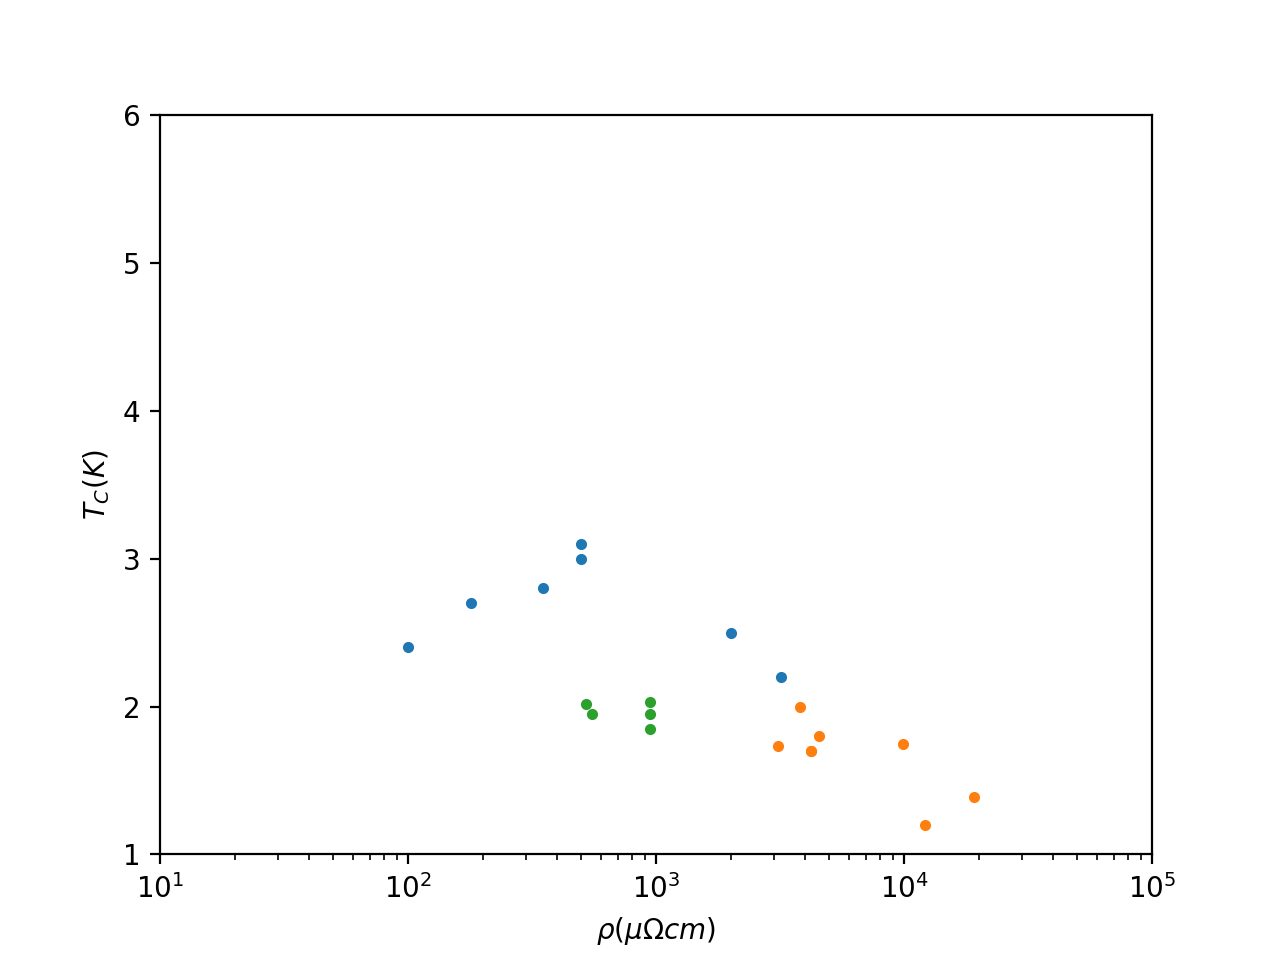

In [165]:
plt.close('all')
f,ax=plt.subplots()
ax.plot(domeLitDF['$\\rho$']*1e8, domeLitDF['$T_C$'], '.')
ax.plot(domeWetDF['$\\rho$']*1e8, domeWetDF['$T_C$'], '.')
ax.plot(domeDryDF['$\\rho$']*1e8, domeDryDF['$T_C$'], '.')

ax.set_xlim(1e-7*1e8,1e-3*1e8)
ax.set_ylim(1,6)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('$T_C (K)$')
ax.set_xscale('log')
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
plt.show()

#### pure Al thin film quality

In [92]:
key =  [ 'w_des',    'R',  'w_real',  'l_real',    'THK', '$R_s$', '$//rho$'   , 'T_C'  ]
lst = [
#SiOx002
       [ 0.2e-6 ,np.nan ,   np.nan ,   np.nan , 17.8e-9 , np.nan ,      np.nan ,    0   ],
       [ 0.5e-6 ,np.nan ,   np.nan ,   np.nan ,   np.nan, np.nan ,      np.nan ,    0   ],
       [   1e-6 ,  52.8 ,  1.51e-6 ,  17.9e-6 ,   40e-9 ,   4.45 ,  0.17816e-6 ,    0   ],
       [   2e-6 ,    18 ,  3.06e-6 ,  12.2e-6 ,   48e-9 ,   4.51 ,  0.21671e-6 ,    0   ],
       [   5e-6 ,  5.78 ,   np.nan ,   np.nan ,   55e-9 , np.nan ,      np.nan ,    0   ],
       [  10e-6 ,  2.86 ,  12.3e-6 ,  11.9e-6 ,   56e-9 ,   2.96 ,  0.16554e-6 ,    0   ],
       [ 0.5e-6 ,np.nan ,   np.nan ,   np.nan ,   23e-9 , np.nan ,      np.nan ,    0   ],
       [   1e-6 ,np.nan ,   np.nan ,   np.nan ,   44e-9 , np.nan ,      np.nan ,    0   ],
       [  10e-6 ,  2.88 ,  12.4e-6 ,    12e-6 , 52.6e-9 ,   2.98 ,  0.15654e-6 ,    0   ],
       [   1e-6 ,    72 , 0.997e-6 ,    16e-6 ,   40e-9 ,   4.49 ,  0.17964e-6 ,    0   ],
#SiOx003
       [ 0.2e-6 ,  1750 ,  0.37e-6 ,  16.3e-6 , 17.8e-9 ,  39.72 ,  0.70709e-6 ,    0   ],
       [ 0.5e-6 ,np.nan ,   np.nan ,   np.nan ,   np.nan, np.nan ,      np.nan ,    0   ],
       [   1e-6 ,  54.5 ,  1.51e-6 ,  15.8e-6 ,   40e-9 ,   5.21 ,  0.20834e-6 ,    0   ],
       [   2e-6 ,    18 ,  2.95e-6 ,  12.3e-6 ,   48e-9 ,   4.31 ,  0.20722e-6 ,    0   ],
       [   5e-6 ,  5.77 ,  7.05e-6 ,  11.8e-6 ,   55e-9 ,   3.44 ,   0.1896e-6 ,    0   ],
       [  10e-6 ,   2.9 ,  12.3e-6 ,  12.3e-6 ,   56e-9 ,   2.9  ,   0.1624e-6 ,    0   ],
       [ 0.5e-6 ,  1050 , 0.466e-6 ,  16.4e-6 ,   23e-9 ,  29.83 ,  0.68621e-6 ,    0   ],
       [   1e-6 ,  53.7 ,  1.48e-6 ,  15.9e-6 ,   44e-9 ,  4.998 ,  0.21993e-6 ,    0   ],
       [  10e-6 ,  2.91 ,  12.1e-6 ,  11.9e-6 , 52.6e-9 ,  2.959 ,  0.15564e-6 ,    0   ],
       [   1e-6 ,  159  ,   np.nan ,   np.nan ,   np.nan, np.nan ,      np.nan ,    0   ],
      ]

thinAlDF = pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()

<IPython.core.display.Javascript object>


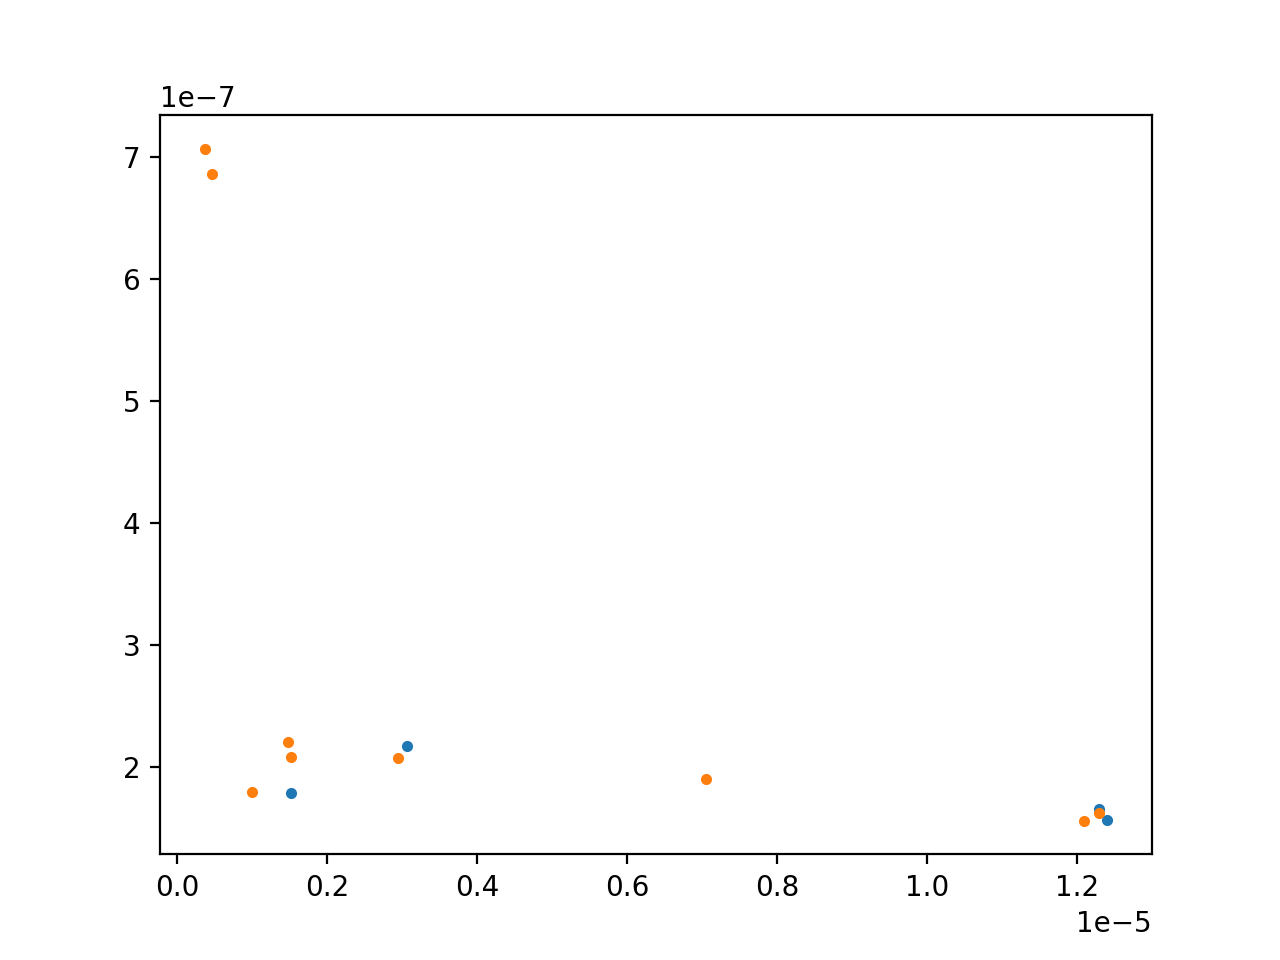

In [97]:
plt.close('all')
f,ax=plt.subplots()
ax.plot(thinAlDF.iloc[:9]['w_real'], thinAlDF.iloc[:9]['$//rho$'], '.')
ax.plot(thinAlDF.iloc[9:]['w_real'], thinAlDF.iloc[9:]['$//rho$'], '.')
ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
plt.show()

## Real products

### Fridge handling log

In [ ]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

# T8.get()

### Search I_SW segments

NameError: name 'filetoDFM' is not defined

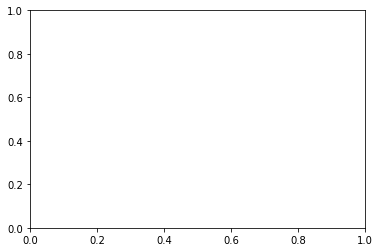

In [11]:
filepath = r'C:\Users\racco\Documents\2experimental log toolbox'

f,ax=plt.subplots()
dataLV = filetoDFM(filepath + r'\191104-70N3_IVc-115218.txt')
ax.plot(dataLV[0]['IS'],dataLV[0]['V1'], '.', ls='-',label = 'meas by LabVIEW')
ax.show()

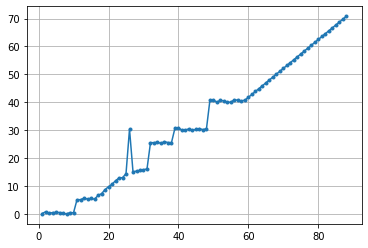

In [9]:
s = 10
lst = np.asarray([])
lsts = [np.random.rand(1,  s)                                 ,
        np.random.rand(1,  5) + 5                             ,
        np.random.rand(1,  s) + 5 + 1*np.linspace(0,s-1,s)    ,
        np.random.rand(1,  1) + s + s*2                       ,
        np.random.rand(1,  1) + s + 5 + 1*np.linspace(0, 1 ,5),
        np.random.rand(1,  7) + s + s*1.5                     ,
        np.random.rand(1, 10) + s + s*2                       ,
        np.random.rand(1, 10) + s + s*3                       ,
        np.random.rand(1,  1) + s*4   +30*np.linspace(0, 1 ,30) ]

for l in lsts:
    lst = np.append(lst, 1*l)

plt.plot(np.linspace(1,len(lst),len(lst)),lst,'.-')
plt.grid(True)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataLV[0]['IS']
dataLV[0]['V1']
lstx = dataLV[0]['IS'].values.tolist()
lst = dataLV[0]['V1'].values.tolist()
datarngs = 0
datarnge = int(np.floor(1*len(lst)/4))
datarngs = int(np.floor(2*len(lst)/4))
datarnge = int(np.floor(3*len(lst)/4))
lstx = lstx[datarngs:datarnge]
lst = lst[datarngs:datarnge]


NameError: name 'lstx' is not defined

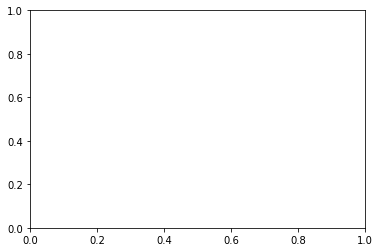

In [13]:
y_thr = 5.5e-3
y_jmp = 0.4e-3

lstd = np.flip(np.append(np.flip(np.diff(lst),0), lst[0]),0)
ids = np.array([])

for i,v in enumerate(lstd):
    if i <= len(lstd)-1 :
        if ((np.abs(v) >= y_jmp) and (np.abs(lstd[i+1]) <= y_jmp)) or (lst[i] >= y_thr):
            ids = np.append(ids, i)
            if lst[i] >= y_thr:
                break

ids = ids.astype(int)
lstNew = np.asarray([])

plt.close('all')
f,ax = plt.subplots()
ax.plot(lstx,lst,'-')
ax.grid(True)

ids = np.flip(np.append(np.flip(ids,0), 0),0)
for i,v in enumerate(ids):
    if i <= len(ids)-2:
        x = lstx[v:ids[i+1]]
        y =  lst[v:ids[i+1]]
        ax.plot(x,y,'.')

plt.show()

### Copy image and show inline

In [ ]:
#This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

import time, os
dir_path = os.getcwd()
pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,
                                                     time.localtime()[1],
                                                     time.localtime()[2],
                                                     time.localtime()[3],
                                                     time.localtime()[4],
                                                     time.localtime()[5])

from PIL import ImageGrab
img = ImageGrab.grabclipboard()
img.save(pngpath, 'PNG')

resize = 2
from PIL import Image
try: 
    img = Image.open(pngpath) 
    width, height = img.size 
    img = img.resize((int(width/resize), int(height/resize))) 
    img.save(pngpath) 
except IOError: 
    pass

from IPython.display import Image, display
display(Image(filename=pngpath))

import clipboard
clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))
# display(Image(filename=r'C:\Users\racco\Documents\2experimental log toolbox\img\19113-124212.png'))

### Strip data strings from dry fridge logs

In [ ]:
import time, datetime

def getTt(filepath, Tch = 0):
    filedate = '21-11-19'
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
#     filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

### Align data with gaps

In [4]:
def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
#             vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
#             vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if v2 == v1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

In [13]:
#x1 = np.linspace(1,20,20)
# y = x1+1

# x2 = np.append(np.linspace(1,10,10),(np.linspace(16,20,5)))
# z = 2*x2+1

x1 = np.linspace(1,200,200)
y1 = np.sin(x1/len(x1)*np.pi*2)

x2 = np.append(np.linspace(1,100,100),(np.linspace(151,200,50)))
y2 = np.cos(x2/len(x1)*np.pi*2)

y2new = fillDataGap(ref_x1 = x1, gapped_x2 = x2, gapped_y2 = y2)

<IPython.core.display.Javascript object>


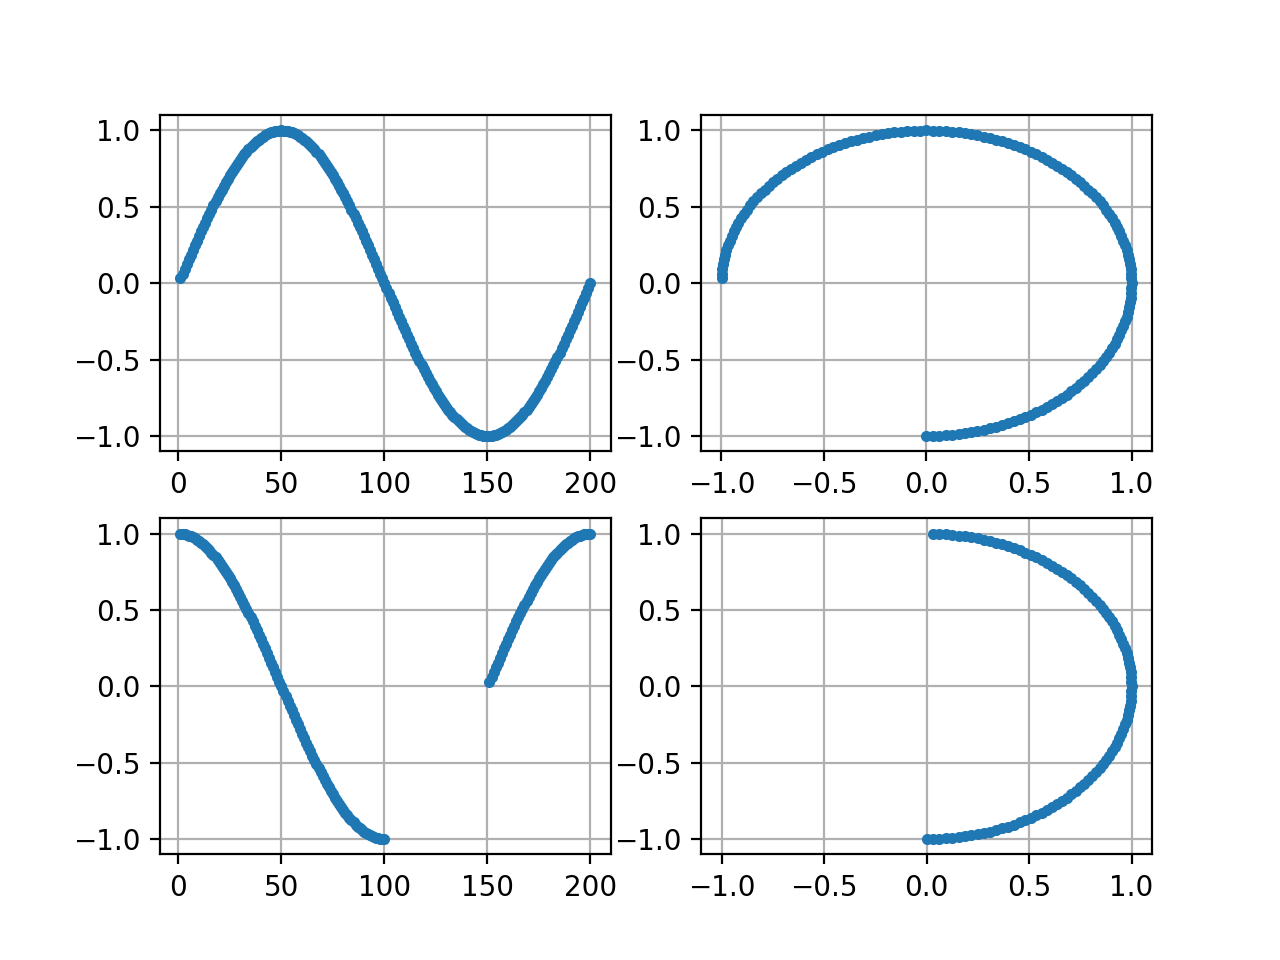

In [14]:
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(x1,y1,'.')
ax[1][0].plot(x2,y2,'.')
ax[0][1].plot(y1,y2new,'.')
ax[1][1].plot(y1[0:100],y2[0:100],'.')

ax[1][1].set_xlim(-1.1,1.1)
ax[1][1].set_ylim(-1.1,1.1)
for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()     
plt.show()